[ Loading Training Data ]  Done
[ Loading Validation Data ]  Done
Prepared Image Shape: (1832, 416, 416, 3), Prepared Label Shape: (1832, 26, 26, 5)
Prepared Image Shape: (98, 416, 416, 3), Prepared Label Shape: (98, 26, 26, 5)
Epoch 1/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - accuracy: 6.5491e-04 - loss: 0.0249 - val_accuracy: 0.0000e+00 - val_loss: 0.0202
Epoch 2/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.0000e+00 - loss: 0.0216 - val_accuracy: 0.0000e+00 - val_loss: 0.0202
Epoch 3/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.0000e+00 - loss: 0.0211 - val_accuracy: 0.0000e+00 - val_loss: 0.0202
Epoch 4/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.0000e+00 - loss: 0.0215 - val_accuracy: 0.0000e+00 - val_loss: 0.0202
Epoch 5/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.0000e+00 - loss: 0.0214 - val_accuracy: 0.0000e+00 - val_loss: 0.0202
Epoch 6/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.0000e+00 - loss: 0

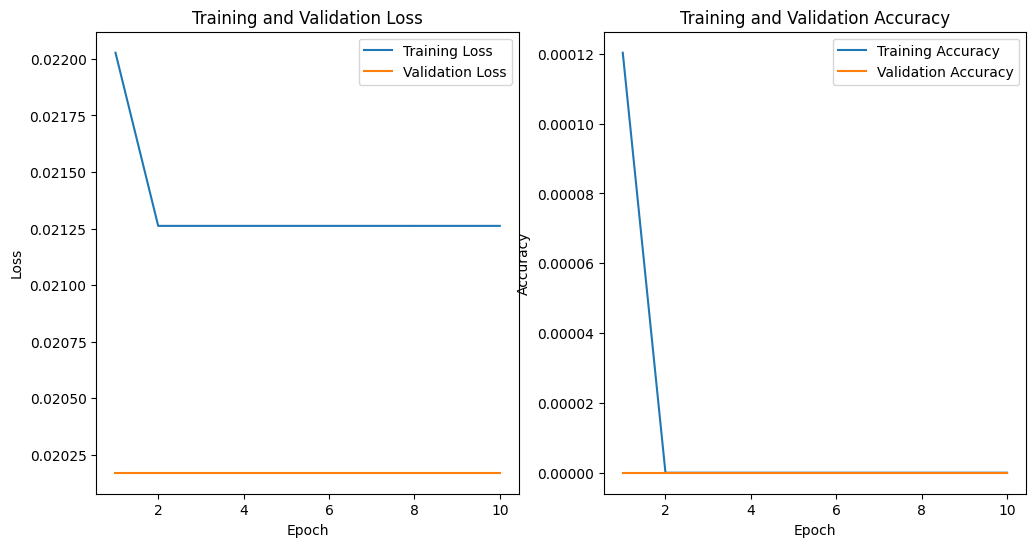

NameError: name 'train_output_folder' is not defined

In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from tensorflow.keras.losses import BinaryCrossentropy

#---------------------------------DataLoader-------------------------------------------
class DataLoader:
    def __init__(self, train_path='./dataset/train/', val_path='./dataset/val/'):
        '''Loads training and validation data'''
        self.train_path = train_path
        self.val_path = val_path
        
        print('[ Loading Training Data ]  ', end='')
        self.train_data = self.load_data(self.train_path)
        print('Done')
        print('[ Loading Validation Data ]  ', end='')
        self.val_data = self.load_data(self.val_path)
        print('Done')
    
    def load_data(self, data_path):
        data = {}
        for patient in os.listdir(os.path.join(data_path, 'images/')):
            for image_name in os.listdir(os.path.join(data_path, 'images/', patient)):
                image_path = os.path.join(data_path, 'images/', patient, image_name)
                img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                
                scan_ID, extension = os.path.splitext(image_name)
                scan_ID = patient + '_' + scan_ID
                data[scan_ID] = [img]

            for mask_name in os.listdir(os.path.join(data_path, 'masks/', patient)):
                mask_path = os.path.join(data_path, 'masks/', patient, mask_name)
                scan_ID, extension = os.path.splitext(mask_name)
                scan_ID = patient + '_' + scan_ID
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                data[scan_ID].append(mask)

            for detection_name in os.listdir(os.path.join(data_path, 'detections/', patient)):
                detection_path = os.path.join(data_path, 'detections/', patient, detection_name)
                detections = self.read_detections(detection_path)

                scan_ID, extension = os.path.splitext(detection_name)
                scan_ID = patient + '_' + scan_ID
                data[scan_ID].append(detections)
        
        for scan in data.values():
            if len(scan) == 2:
                scan.append(None)
        return data
    
    def read_detections(self, path):
        detections = []
        with open(path, 'r') as file:
            for line in file:
                coordinates = [int(num.strip()) for num in line.split(',')]
                detections.append(tuple(coordinates))
        return tuple(detections)

    def prepare_data_for_detections(self, data):
        images = []
        labels = []
        
        grid_size = 26
        num_predictions = 5 * grid_size * grid_size  # 5 values per grid cell (x, y, w, h, confidence)
    
        for scan_ID, scan_data in data.items():
            image = scan_data[0]  
            detections = scan_data[2]  
        
            # Resize image to 416x416 and convert grayscale to RGB by repeating channels
            image_resized = cv2.resize(image, (416, 416))
            image_resized_rgb = np.stack([image_resized] * 3, axis=-1)  
            images.append(image_resized_rgb)
        
            # Initialize label with a grid size of (13, 13, 5) — 5 values: (x, y, w, h, confidence)
            label = np.zeros((grid_size, grid_size, 5)) 
        
            if detections is not None:  # Ensure detections is not None before iterating
                for box in detections:
                    x_min, y_min, x_max, y_max = box
                    # Normalize coordinates
                    height, width = image.shape
                    x_center = (x_min + x_max) / 2 / width
                    y_center = (y_min + y_max) / 2 / height
                    box_width = (x_max - x_min) / width
                    box_height = (y_max - y_min) / height
                    
                    # Determine which grid cell the center of the bounding box falls into
                    grid_x = int(x_center * grid_size)
                    grid_y = int(y_center * grid_size)
            
                    # Mark the box in the label grid and set objectness to 1 (indicating an object is present)
                    label[grid_y, grid_x] = [x_center, y_center, box_width, box_height, 1]  # Confidence is 1 for an object present
                
            labels.append(label)
        
        # Convert images and labels to numpy arrays with correct shapes
        images = np.array(images)
        labels = np.array(labels)
        
        print(f"Prepared Image Shape: {images.shape}, Prepared Label Shape: {labels.shape}")  # Debugging line
        
        return images, labels

    def prepare_data_for_segmentation(self, data):
        images = []
        masks = []

        for scan_ID, scan_data in data.items():
            image = scan_data[0]
            mask = scan_data[1]

            # Resize image and mask to a fixed size
            image = cv2.resize(image, (256, 256))
            mask = cv2.resize(mask, (256, 256))

            # Normalize image pixels to [0, 1]
            image = image / 255.0

            # Convert mask to binary
            mask = (mask > 0).astype(np.uint8)

            images.append(image)
            masks.append(mask)

        images = np.array(images)
        masks = np.array(masks)

        return images, masks
        

#--------------------------------------DetectionTask--------------------------------------
def build_yolo_model(input_shape=(416, 416, 3), grid_size=26):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    
    # Final detection layer
    x = layers.Conv2D(5, (1, 1), activation='sigmoid')(x)  # (batch, grid_size, grid_size, 5)
    
    model = models.Model(inputs, x)
    return model


def yolo_loss(y_true, y_pred):
    # Bounding box loss
    bbox_true = y_true[..., :4]
    bbox_pred = y_pred[..., :4]
    bbox_loss = K.sum(K.square(bbox_true - bbox_pred) * y_true[..., 4:5], axis=-1) #considering removing multiplication by labels

    # Confidence loss
    obj_true = y_true[..., 4:5]
    obj_pred = y_pred[..., 4:5]
    obj_loss = K.sum(K.binary_crossentropy(obj_true, obj_pred), axis=-1)

    # Total loss
    return K.mean(bbox_loss + obj_loss)


def train_yolo_model(model, train_data, val_data, epochs=10, batch_size=4):
    train_images, train_labels = train_data
    val_images, val_labels = val_data

    model.compile(
    optimizer='adam',
    loss=yolo_loss,  # Use custom YOLO loss function
    metrics=['accuracy']
    )


    # Initialize lists to store training and validation metrics
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")

        # Train the model
        history = model.fit(train_images, train_labels, epochs=1, batch_size=batch_size, validation_data=(val_images, val_labels))

        # Append training and validation metrics to the lists
        train_losses.append(history.history['loss'][0])
        val_losses.append(history.history['val_loss'][0])
        train_accuracies.append(history.history['accuracy'][0])
        val_accuracies.append(history.history['val_accuracy'][0])

    # Plot the training and validation loss and accuracy curves
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
    plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs+1), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.show()

#---------------------------------------------DetectionOutput------------------------------
def process_and_save_images_with_bboxes(model, data_loader, dataset_type, output_folder, batch_size=4, confidence_threshold=0.5):
    """
    Processes the dataset images and saves them with bounding boxes in organized folders.
    Args:
        model: Trained YOLO model.
        data_loader: DataLoader object containing train and val data.
        dataset_type: Either "train" or "val" to specify the dataset.
        output_folder: Folder where processed images will be saved.
        batch_size: Batch size for predictions to speed up processing.
    """
    # Ensure the output folder exists
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Select dataset
    data = data_loader.train_data if dataset_type == "train" else data_loader.val_data

    print(f"Processing {dataset_type} dataset...")
    grid_size = 26  # Assuming YOLO grid size
    
    # Create batches of images
    image_batch = []
    image_paths = []
    for image_path, scan_data in data.items():
        image = scan_data[0]  # Original grayscale image
        if image is None:
            print(f"Could not read image for {image_path}. Skipping.")
            continue

        # Convert grayscale to RGB and resize
        image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        image_resized = cv2.resize(image_rgb, (416, 416))  
        image_batch.append(image_resized / 255.0)  # Normalize image
        image_paths.append(image_path)
        
        if len(image_batch) == batch_size:
            # Predict bounding boxes for the batch
            batch_images = np.array(image_batch)
            batch_predictions = model.predict(batch_images)

            # Process each image in the batch
            for i, prediction in enumerate(batch_predictions):
                image_rgb = batch_images[i]  # Image with bounding boxes
                original_image_path = image_paths[i]  # Path to save

                # Process predictions
                for i in range(grid_size):
                    for j in range(grid_size):
                        box = prediction[i, j, :]
                        confidence = box[4]  # Confidence score for the detected object

                        # If confidence is high enough (threshold of 0.5), draw the box
                        if confidence > confidence_threshold:
                            x_center, y_center, width, height = box[:4]

                            # Convert the box coordinates back to the original image size
                            x_min = int((x_center - width / 2) * 416)
                            y_min = int((y_center - height / 2) * 416)
                            x_max = int((x_center + width / 2) * 416)
                            y_max = int((y_center + height / 2) * 416)

                            # Ensure bounding box coordinates are within image bounds
                            x_min = max(0, x_min)
                            y_min = max(0, y_min)
                            x_max = min(416, x_max)
                            y_max = min(416, y_max)

                            # Draw bounding box on the image
                            cv2.rectangle(image_rgb, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

                            # Draw the confidence score
                            label = f"{confidence:.2f}"
                            label_position = (x_min, y_min - 10 if y_min > 20 else y_min + 10)
                            cv2.putText(image_rgb, label, label_position, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

                # Save the processed image in the output folder
                output_path = os.path.join(output_folder, f"{os.path.basename(original_image_path)}.png")
                cv2.imwrite(output_path, image_rgb)

            # Clear the batch for the next set of images
            image_batch = []
            image_paths = []

    print(f"Processed {dataset_type} dataset images are saved in {output_folder}.")

#----------------------------------------------SegmentationTask------------------------------
def build_unet_model(input_shape=(256, 256, 1)):
    inputs = Input(shape=input_shape)

    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # ... (similar layers for deeper levels)

    # Decoder
    up7 = UpSampling2D(size=(2, 2))(conv2)
    concat7 = Concatenate()([up7, conv1])
    conv8 = Conv2D(64, 3, activation='relu', padding='same')(concat7)
    conv8 = Conv2D(64, 3, activation='relu', padding='same')(conv8)

    # ... (similar layers for shallower levels)

    outputs = Conv2D(1, 1, activation='sigmoid')(conv8)
    model = Model(inputs=inputs, outputs=outputs)
    return model

def unet_loss(y_true, y_pred):
  """
  U-Net loss function combining binary cross-entropy and Dice loss.

  Args:
    y_true: Ground truth segmentation masks.
    y_pred: Predicted segmentation masks.

  Returns:
    Combined loss.
  """

  # Binary cross-entropy loss
  bce = BinaryCrossentropy()(y_true, y_pred)

  # Dice loss
  smooth = 1.0
  intersection = tf.reduce_sum(y_true * y_pred)
  union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
  dice = (2. * intersection + smooth) / (union + smooth)
  dice_loss = 1 - dice

  # Combined loss
  loss = bce + dice_loss

  return loss

def train_Unet_model(model, train_images, train_masks, val_images, val_masks, epochs=10, batch_size=32):
    model.compile(optimizer='adam', loss=BinaryCrossentropy(), metrics=['accuracy', MeanIoU()])

    history = model.fit(train_images, train_masks, epochs=epochs, batch_size=batch_size, validation_data=(val_images, val_masks))

    return history

#------------------------------------SegmentationOutput----------------------------------

def process_and_save_segmentation_masks(model, images, output_folder):
    for i, image in enumerate(images):
        prediction = model.predict(np.expand_dims(image, axis=0))
        mask = (prediction[0, :, :, 0] > 0.5).astype(np.uint8) * 255
        cv2.imwrite(os.path.join(output_folder, f"mask_{i}.png"), mask)


#read dataset
train_path = '/kaggle/input/lungtumordetectionandsegmentation/train'
val_path = '/kaggle/input/lungtumordetectionandsegmentation/val'

data_loader = DataLoader(train_path, val_path)
train_data = data_loader.prepare_data_for_detections(data_loader.train_data)
val_data = data_loader.prepare_data_for_detections(data_loader.val_data)

# Build and train the model of detections
yolo_model = build_yolo_model()
train_yolo_model(yolo_model, train_data, val_data, epochs=10, batch_size=8)

# Define output folders for processed images of detections
train_detect_output_folder = '/kaggle/working/detection_output/train'
val_detect_output_folder = '/kaggle/working/detection_output/val'

# Process and save all images with bounding boxes drawn for detections
process_and_save_images_with_bboxes(yolo_model, data_loader, "train", train_output_folder)
process_and_save_images_with_bboxes(yolo_model, data_loader, "val", val_output_folder)

# Build and train the model of segmentation
unet_model = build_unet_model()
history = train_Unet_model(model, (train_images, train_masks), (val_images, val_masks))

# Define output folders for processed images of segmentations
train_segment_output_folder = '/kaggle/working/segmentation1_output/train'
val_segment_output_folder = '/kaggle/working/segmentation1_output/val'

# Process and save all masks drawn for segmentations
process_and_save_segmentation_masks(unet_model, data_loader, "train", train_segment_output_folder)
process_and_save_segmentation_masks(unet_model, data_loader, "val", val_segment_output_folder)